In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import pi, c
from scipy import signal

# GIF GEN

from PIL import Image
import glob
import re

# Loading bar

from tqdm import tqdm

# Low matplot lib resolution
plt.rcParams['figure.dpi'] = 100

# Ideal point target data generation

In [4]:
# Single moving target

def generate_trajectory(T=40, dt=0.02, v=5, trajectory_type="sinusoidal"):
    """
    Generate a simulated target trajectory. Ideal Point Target.

    Parameters:
        T (float): Total simulation time in seconds.
        dt (float): Time step in seconds / resolution.
        speed (float): Constant speed of the target in m/s.
        trajectory_type (str): Type of trajectory ("linear", "sinusoidal", "random").

        add RCS in dBsm?

    Returns:
        x, y, vx, vy (numpy arrays)
    """

    num_steps = int(T / dt)

    # Initialize arrays for position and velocity
    x = np.zeros(num_steps)
    y = np.zeros(num_steps)

    # Initial position
    x[0], y[0] = 1, 0

    # Generate trajectory based on type
    for i in range(1, num_steps):
        x[i] = x[i-1] + v * dt  # Always move forward in x

        if trajectory_type == "linear":
            y[i] = y[i-1]  # Straight line
        elif trajectory_type == "sinusoidal":
            y[i] = -1 + 10 * np.sin(0.1 * x[i])  # Sine wave path
        elif trajectory_type == "random":
            y[i] = y[i-1] + np.random.uniform(-2, 2)  # Random small movements

    # Calculate velocity
    vx = np.gradient(x, dt)
    vy = np.gradient(y, dt)


    return y, x, vx, vy

def plot_trajectory(x, y, title="Simulated Target Motion"):
    """Plot the trajectory."""
    plt.figure(figsize=(8, 6))
    plt.plot(x, y, label="Ground Truth", color="black")
    plt.xlabel("Range [m]")
    plt.ylabel("Range [m]")
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

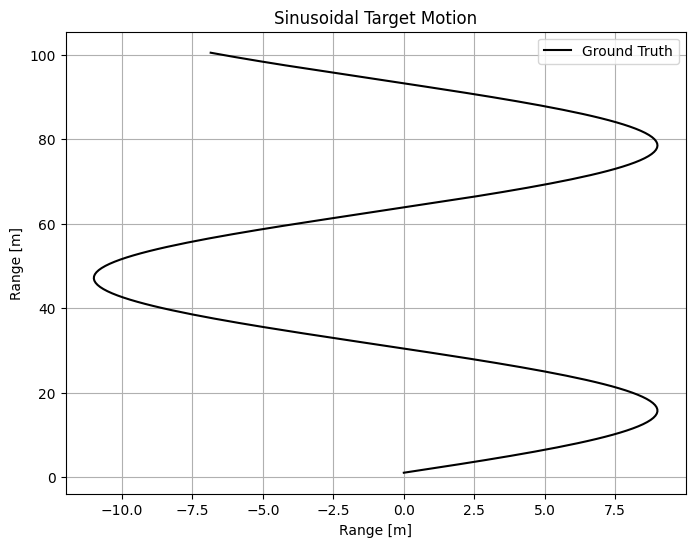

(200,)


In [5]:
# Example usage
x, y, vx, vy = generate_trajectory(T=20, dt=0.1, v=5, trajectory_type="sinusoidal")
plot_trajectory(x, y, title="Sinusoidal Target Motion")
print(x.shape)

# Radar Model - MIMO

In [6]:
# MIMO radar setup

""" TRANSMITTER TXs"""

f_c = 77e9        # start frequency - [Hz]
wavelength = c/f_c  # Lambda wakelength at carrier frequency - [m]

T_c = 25.66e-6      # chirp time/ duration - [s]
bw = 0.77*1e9           # bandwidth eg. from 76. GHz to 77.5 GHz - [Hz]
S = bw/T_c          # chirp rate - [Hz/s]
prf = 1/T_c         # pulse repetition frequency - [Hz]

M = 128             # number of chirps

TX_locations = np.array(([-8*(wavelength/2), 0],
                        [-4*(wavelength/2), 0],
                        [0, 0])) # remeber to set 1 TX like this : np.array([[0, 0]]) ensure shape (1,2)
                        #[-3*wavelength, 0]))    # Transmitter location on 2-dimensional plane [m]

                                    # TI har 3 transmitter
                                    # Unilateral antenna array: 1 lambda spacing between antennas


""" RECEIVER RXs"""

fs = 20e6           # sampling frequency - [Hz]
Ns = 128          # number of samples (ADC) - [samples]

RX_locations = np.array(([1*(wavelength/2), 0],
                        [2*(wavelength/2), 0],
                        [3*(wavelength/2), 0],
                        [4*(wavelength/2), 0]))  # Receiver location on 2-dimensional plane [m]
    
                                    # TI har 4 receiver
                                    # Unilateral antenna array: 1/2 lambda spacing between antennas

""" Path loss """

gain = 1            # gain of the antenna - [dB]
transmit_power = 1  # transmit power - [W]
rcs = 1             # radar cross section - [m^2]

"""Computation of update rate"""

# Update rate

T_frame = M*T_c     # frame time - [s]

print(f"Frame time: {T_frame} s")

""" Extra """

max_range = (fs*c)/(2*S)
max_vel = wavelength / (4 * T_c) # m/s

ranges = np.linspace(0, max_range, Ns)

Frame time: 0.00328448 s


0
2
4


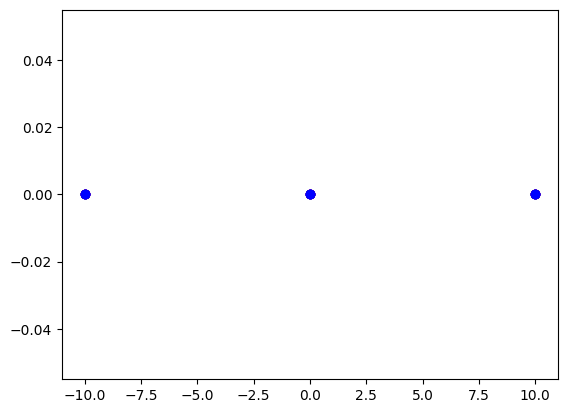

In [7]:
# Multiple MIMO radar setup

def generate_extra_mimo_radar_coordinates(origin_mimo_setup_TX, origin_mimo_setup_RX, mimo_start):

    mimo_locations_TX = np.zeros((origin_mimo_setup_TX.shape[0], 2))
    mimo_locations_RX = np.zeros((origin_mimo_setup_RX.shape[0], 2))

    for i in range(origin_mimo_setup_TX.shape[0]):
        mimo_locations_TX[i] = origin_mimo_setup_TX[i] + np.array([mimo_start, 0])
    for i in range(origin_mimo_setup_RX.shape[0]):
        mimo_locations_RX[i] = origin_mimo_setup_RX[i] + np.array([mimo_start, 0])

    return mimo_locations_TX, mimo_locations_RX

TX_locations_0, RX_locations_0 = generate_extra_mimo_radar_coordinates(TX_locations, RX_locations, -10)
TX_locations_1, RX_locations_1 = generate_extra_mimo_radar_coordinates(TX_locations, RX_locations, 0)
TX_locations_2, RX_locations_3 = generate_extra_mimo_radar_coordinates(TX_locations, RX_locations, 10)

radars = [TX_locations_0, RX_locations_0, TX_locations_1, RX_locations_1, TX_locations_2, RX_locations_3]

for i in range(0, len(radars), 2):
    print(i)
    plt.scatter(radars[i][:, 0], radars[i][:, 1], color="red", label="TX")
    plt.scatter(radars[i+1][:, 0], radars[i+1][:, 1], color="blue", label="RX")

# SNR computations

In [8]:
# SNR:

SNR = 10 # dB
SNR_distance = 10 # m

snr_linear = 10 ** (SNR / 10)

recieved_power = ((transmit_power * gain * (wavelength ** 2) * rcs) / (((4 * pi) ** 3) * ((SNR_distance) ** 4)))
noise_power = recieved_power / snr_linear

snr_linear, recieved_power, noise_power

(10.0, 7.638891885764579e-13, 7.638891885764579e-14)

In [9]:
# distance for different dBs at current noise_power:

SNR = 10 # dB

snr_linear = 10 ** (SNR / 10)

recieved_power_10db = noise_power*snr_linear

SNR_distance_10db = ((transmit_power * gain * (wavelength ** 2) * rcs)/(((4 * pi) ** 3 * recieved_power_10db))) ** (1/4)

SNR_distance_10db

10.0

In [10]:
# distance for different dBs at current noise_power:

SNR = 5 # dB

snr_linear = 10 ** (SNR / 10)

recieved_power_5db = noise_power*snr_linear

SNR_distance_5db = ((transmit_power * gain * (wavelength ** 2) * rcs)/(((4 * pi) ** 3 * recieved_power_5db))) ** (1/4)

SNR_distance_5db


13.33521432163324

In [11]:
# distance for different dBs at current noise_power:

SNR = 0 # dB

snr_linear = 10 ** (SNR / 10)

recieved_power_0db = noise_power*snr_linear

SNR_distance_0db = ((transmit_power * gain * (wavelength ** 2) * rcs)/(((4 * pi) ** 3 * recieved_power_0db))) ** (1/4)

SNR_distance_0db


17.78279410038923

In [12]:
# distance for different dBs at current noise_power:

SNR = -10 # dB

snr_linear = 10 ** (SNR / 10)

recieved_power_m10db = noise_power*snr_linear

SNR_distance_m10db = ((transmit_power * gain * (wavelength ** 2) * rcs)/(((4 * pi) ** 3 * recieved_power_m10db))) ** (1/4)

SNR_distance_m10db


31.622776601683793

# Simulation

In [13]:
"""Compute all radial velocities from the target to the TXs and RXs"""

def compute_radial_velocity(x_target, y_target, x_target_velocity, y_target_velocity, x_base, y_base):
    dx = x_target - x_base
    dy = y_target - y_base
    distance = np.sqrt(dx**2 + dy**2)
    radial_velocity = (dx * x_target_velocity + dy * y_target_velocity) / distance
    return radial_velocity

In [14]:
""" Compute intermediate frequency (IF) signal frequency for TX-RX pair """

def compute_IF(r_TX, r_RX):
    IF_signal = (S*(r_TX+r_RX))/ c
    return IF_signal

""" Compute the phase shift of the IF signal """

def compute_phase_shift():
    phase_shift = 2*pi*f_c*(2*(v_RX[0]*T_c)/c)
    return phase_shift

""" Compute the phase difference between the TX and RX antenna pairs"""

def compute_phase_diff(r_tx, r_rx):
    phase_diff = (2*pi*(r_tx + r_rx)) / wavelength % (2*pi)
    #phase_diff = (2*pi*r_rx*np.sin(np.deg2rad(45)))/wavelength % (2*pi)
    return phase_diff

In [15]:
def extract_phasor_for_covariance_matrix(fft_2d):
    """
    Extracts the complex phasor from the 2D FFT peak location.

    Parameters:
    fft_2d : np.array
        2D FFT output.

    Returns:
    phasor : complex
        Complex phasor at the peak location.
    """

    # Find peak location in FFT
    peak_index = np.unravel_index(np.argmax(np.abs(fft_2d)), fft_2d.shape)

    # Extract phasor at the peak position and two phasors above and below
    phasors = []
    for i in range(-2, 3):
        idx = (peak_index[0] + i) % fft_2d.shape[0]
        phasors.append(fft_2d[idx, peak_index[1]])
    return phasors # This only return distance bin index and phasors for angle !!!

In [16]:
def doa_music(R, n_sig, d = 0.5, scan_angles = range(-90, 91)):
    """ MUSIC algorithm implementation """
    n_array = np.shape(R)[0]
    array = np.linspace(0, (n_array - 1) * d, n_array)
    scan_angles = np.array(scan_angles)

    # 'eigh' guarantees the eigen values are sorted
    _, e_vecs = np.linalg.eigh(R)
    noise_subspace = e_vecs[:, :-n_sig]

    array_grid, angle_grid = np.meshgrid(array, np.radians(scan_angles), indexing = "ij")
    steering_vec = np.exp(-1.j * 2 * np.pi * array_grid * np.sin(angle_grid)) 
    
    # 2-norm (frobenius)
    ps = 1 / np.square(np.linalg.norm(steering_vec.conj().T @ noise_subspace, axis = 1))

    return 10 * np.log10(ps)

In [17]:
radars[1][0][0]

np.float64(-9.998053295727273)

In [18]:
times = np.linspace(0, Ns/fs, Ns)
window_NS = signal.windows.blackman(Ns)
window_M = signal.windows.blackman(M)

distance_bins = np.linspace(0, max_range, Ns)
anglebins = np.linspace(-90, 90, 1001)

for time_step in tqdm(range(len(x))):
    """Compute all radial distances from the target to the TXs and RXs"""
    target_location = np.array([x[time_step], y[time_step]])
    r_TX = np.linalg.norm(TX_locations - target_location, axis=1)
    r_RX = np.linalg.norm(RX_locations - target_location, axis=1)

    """Compute all radial velocities from the target to the TXs and RXs"""
    target_velocity = np.array([vx[time_step], vy[time_step]])
    v_TX = compute_radial_velocity(target_location[0], target_location[1], target_velocity[0], target_velocity[1], TX_locations[0][0], TX_locations[0][1])
    v_RX = compute_radial_velocity(target_location[0], target_location[1], target_velocity[0], target_velocity[1], RX_locations[:,0], RX_locations[:,1])

    """ Compute the intermediate frequencies for all TX-RX pairs """

    IF_signals = np.zeros((len(TX_locations), len(RX_locations)))

    for t in range(len(TX_locations)):
        for r in range(len(RX_locations)):
            IF_signals[t, r] = compute_IF(r_TX[t], r_RX[r]) # add index to r_TX for multiple transmitters 

    """ Compute the phase shift of the IF signal """

    phase_diff = compute_phase_shift() # rad

    """ Comput the phase difference between the TX and RX antenna pairs """

    phase_diff_antennas = np.zeros((len(TX_locations), len(RX_locations)))

    for t in range(len(TX_locations)):
        for r in range(len(RX_locations)):
            phase_diff_antennas[t, r] = compute_phase_diff(r_TX[t], r_RX[r]) # # add index to r_TX for multiple transmitters 

    """ Create all frames for all TX-RX pair IF signals """

    IF_signals_data = {}

    for t in range(len(TX_locations)):
        for r in range(len(RX_locations)):
            
            frame = np.zeros((M, Ns), dtype=complex)
            for m in range(M):
                frame[m, :] = (
                (np.sqrt((transmit_power * gain * (wavelength ** 2) * rcs) / (((4 * pi) ** 3) * ((r_RX[r]) ** 4))))
                * np.exp(1j * (2 * pi * IF_signals[t, r] * times + m * phase_diff + phase_diff_antennas[t, r]))
                )
                complex_noise = np.sqrt(noise_power/2) * (np.random.normal(0, 1, frame[m, :].shape) + 1j * np.random.normal(0, 1, frame[m, :].shape))
                
                # Compute the power of the current signal
                signal_power = np.mean(np.abs(frame[m, :])**2)

                noise_power_computed = np.mean(np.abs(complex_noise)**2)
            
                # Compute the SNR
                snr_measured = signal_power / noise_power_computed


                # Add noise and window function
                frame[m, :] += complex_noise
                frame[m, :] *= window_NS
                
            IF_signals_data[(t, r)] = frame # Dette er jo egentlig bare en frame
    
    """ Compute the range-Doppler map for all TX-RX pairs """ # Only adds overhead of about 33 % of sim time.

    range_doppler_rxs = {}

    for idx, (key, frame) in enumerate(IF_signals_data.items()):
        range_doppler = np.fft.fftshift(np.fft.fft2(frame.T*window_M), axes=1) / (Ns / 2)
        range_doppler_rxs[idx] = range_doppler



    """ Plot target tracking """

    phasors = np.array([extract_phasor_for_covariance_matrix(range_doppler_rxs[i]) for i in range(len(range_doppler_rxs))])

    radial_distance = np.unravel_index(np.argmax(np.abs(range_doppler_rxs[0])), range_doppler_rxs[0].shape)[0]

    R = phasors @ phasors.conj().T*(1/5) # Covariance matrix

    music_angle = doa_music(R, 1, scan_angles = np.linspace(-90, 90, 1001))

    deteceted_angle = anglebins[np.argmax(music_angle)]

    #print(distance_bins[radial_distance], deteceted_angle)

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 8))

    ax1.plot(x, y, label="Ground Truth", color="black")
    ax1.scatter(x[time_step], y[time_step],  marker='x', color="blue", label="Target Position")

    ax1.plot(distance_bins[radial_distance]*np.cos(np.deg2rad(90-deteceted_angle)), distance_bins[radial_distance]*np.sin(np.deg2rad(90-deteceted_angle)), '-ro', label="Detected Position")
    ax1.plot(0, 0, marker='D', color='y', label="Radar Position")
    cir_10db = plt.Circle((0, 0), SNR_distance_10db, color='g', fill=False, linestyle='--', label="10 dB")
    ax1.add_patch(cir_10db)
                 
    cir_5db = plt.Circle((0, 0), SNR_distance_5db, color='b', fill=False, linestyle='--', label="5 dB")
    ax1.add_patch(cir_5db)

    cir_0db = plt.Circle((0, 0), SNR_distance_0db, color='r', fill=False, linestyle='--', label="0 dB")
    ax1.add_patch(cir_0db)

    cir_m10db = plt.Circle((0, 0), SNR_distance_m10db, color='black', fill=False, linestyle='--', label="-10 dB")
    ax1.add_patch(cir_m10db)


    ax1.grid()
    ax1.set_xlim([-15, 15])
    ax1.set_ylim([0, 100])
    ax1.set_xlabel("x-position [m]", fontsize=14)
    ax1.set_ylabel("y-position [m]", fontsize=14)
    ax1.legend()


    """ Save plot of range-Doppler map for one TX-RX pair """

    # Select the first range-Doppler map
    first_key = list(range_doppler_rxs.keys())[0]
    range_doppler = range_doppler_rxs[first_key]

    extent = [-max_vel, max_vel, ranges.min(), ranges.max()]

    range_doppler_plot = ax2.imshow(
        20 * np.log10(np.abs(range_doppler)),  # np.abs(...): Takes the magnitude, removing the phase.
        aspect="auto",
        extent=extent,
        origin="lower",
        vmax=-50,
        vmin=-150,
    )
    ax2.set_ylim([0, 100])
    ax2.set_xlabel("Velocity (m/s)", fontsize=14)
    ax2.set_ylabel("Range (m)", fontsize=14)
    fig.colorbar(range_doppler_plot, ax=ax2, orientation='vertical', fraction=0.02, pad=0.04)
    ax2.set_title(f"SNR: {10 * np.log10(snr_measured):.2f}dB", fontsize=16)
    
    plt.savefig(f"C:\\Users\\malth\\OneDrive - Aarhus Universitet\\Dokumenter\\AAU-Studie\\10. semester\\GIT\\master_thesis\\sim_figs\\range_doppler_{time_step}.png")
    plt.close()

100%|██████████| 200/200 [01:14<00:00,  2.67it/s]


# Generate GIF

In [19]:
# Folder containing PNG files
folder_path = r"C:\Users\malth\OneDrive - Aarhus Universitet\Dokumenter\AAU-Studie\10. semester\GIT\master_thesis\sim_figs"

# Get all PNG files matching pattern
image_files = glob.glob(f"{folder_path}\\range_doppler_*.png")

# Sort numerically based on the number in the filename
def extract_number(filename):
    match = re.search(r"range_doppler_(\d+)\.png", filename)
    return int(match.group(1)) if match else float('inf')

image_files = sorted(image_files, key=extract_number)

# Open images
images = [Image.open(img) for img in image_files]

# Save as GIF
output_path = f"{folder_path}\\range_doppler_animation.gif"
images[0].save(output_path, save_all=True, append_images=images[1:], duration=100, loop=1, optimize=False)

print(f"GIF saved at {output_path}")

GIF saved at C:\Users\malth\OneDrive - Aarhus Universitet\Dokumenter\AAU-Studie\10. semester\GIT\master_thesis\sim_figs\range_doppler_animation.gif
